In [1]:
# Kickstarter launched on April 28, 2009

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# read in all our data
df = pd.read_csv("./ks-projects-201801.csv")

In [2]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
#split the launched column into separate dates an times, and add into the dataframe
df_launched_split = pd.DataFrame(df['launched'].str.split(' ').tolist(), columns = ['launch_date','launch_time'])
df_1 = pd.concat([df, df_launched_split], axis=1)

#convert to readily used datetime values
df_1['launched'] = pd.to_datetime(df_1['launched'])
df_1['deadline'] = pd.to_datetime(df_1['deadline'])
df_1['launch_date'] = pd.to_datetime(df_1['launch_date'])
df_1['launch_year'] = df_1['launched'].dt.year
df_1['launch_month'] = df_1['launched'].dt.month
# df_1['launch_year_month'] = df_1.launched.dt.to_period('M')
df_1['launch_year_month'] = df_1['launch_date'].apply(lambda dt: dt.replace(day=1))

#now create a column and a simple equation to calculate the total days each campaign went
df_1['duration'] = df_1['deadline'] - df_1['launch_date']
df_1['duration'] = df_1['duration'] / np.timedelta64(1, 'D')
df_1['duration'] = df_1['duration'].astype('int64')
# 378661 rows

# Remove rows with erroneous launched value from df (7 rows)
df_1 = df_1[df_1.launched != '1970-01-01 01:00:00']
# 378654 rows

# Project state values : ['live', 'failed', 'canceled', 'successful', 'undefined', 'suspended']

# Remove rows with state = 'live' (2799 rows). Reason: don't know if funded successfully
df_1 = df_1[df_1.state != 'live']
# 375855 rows

# Remove rows with messed up data (3796 rows). Reason: these rows have backers = 0, state = undefined, etc. Too messy.
df_1 = df_1[ df_1.country != 'N,0"' ]
# 372059 rows

# Remove rows with launch_year = 2018 (2 rows)
df_1 = df_1[ df_1['launch_year'] != 2018 ]
# 372057 rows

# For projects with state = 'undefined', use best guess to determine state accoding to pledged and goal amounts
# simply replace it with either successful or failed because these two categories are much larger than canceled and suspended
# df_1.loc[(df_1.state == 'undefined') & (df.pledged >= df.goal), 'state'] = 'successful'
# df_1.loc[(df_1.state == 'undefined') & (df.pledged < df.goal), 'state'] = 'failed'

# There are 4 rows with NaN in the 'name' column. Not a problem because we're not looking at project names.
df_1 = df_1[df_1.name.notnull()]

# Another 3797 with NaN in the 'usd pledged' column. Not a problem because we can use usd_pledged_real, which is pretty much equivalent.
# Also these 3797 rows has value 'N,0"' in the 'country' column, making them un
# df_1 = df_1[df_1['usd pledged'].notnull()]

# Attempt to fill in the 'country' column accoding to value in the 'currency' column
# 186 rows has currency = 'EUR', which can be many different european countries, so we're going to skip these.
# Removing 186 rows with currency = 'EUR' and unknown country
# df_1 = df_1[ ~ ((df_1.currency == 'EUR') & (df_1['country'] == 'N,0"'))]
# 375669 rows
# 3611 rows has currency in   ['USD', 'AUD', 'CAD', 'GBP', 'SEK', 'DKK', 'NZD', 'NOK', 'CHF']
# which correspond to country ['US',  'AU',  'CA',  'GB',  'SE',  'DK' , 'NZ',  'NO',  'CH']
# AU: Australia, SE: Sweden, DK: Denmark, NZ: New Zealand, NO: Norway, CH: Switzerland
# df_1.loc[(df_1.country == 'N,0"') & (df_1.currency != 'EUR'), 'country'] = df_1.currency.str.slice(0, -1)

# df_1 = df_1[df_1.currency == 'CHF']
# df_1 = df_1[df_1['usd pledged'].isnull()]
# df_1 = df_1[df_1.country == 'N,0"']
# df_1 = df_1[df_1.state == 'undefined']
# df_1 = df_1[df_1.state == 'live']
# df_1.state.value_counts()
# df_1.state.unique()

# sort df_1 by launch date
df_1 = df_1.sort_values(by='launched')

# Add a column of goal amount in log scale
df_1['usd_goal_real_log'] = np.log10(df_1['usd_goal_real'])

# Add a column of goal amount in log scale
df_1['pledged_per_backer'] = np.where(df_1['backers']==0, 0, df_1['usd_pledged_real']/df_1['backers'])

# Create a df_2 containing only pledged_per_backer != 0
df_2 = df_1.copy()
df_2 = df_2[df_2['pledged_per_backer'] != 0]
df_2['pledged_per_backer_log'] = np.log10(df_2['pledged_per_backer'])

# See if pledged_per_backer distribution is different for successful projects only
df_3 = df_2.copy()
df_3 = df_3[df_3.state == 'successful']

# Display df_1
df_1

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,usd_pledged_real,usd_goal_real,launch_date,launch_time,launch_year,launch_month,launch_year_month,duration,usd_goal_real_log,pledged_per_backer
169268,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21 21:02:48,625.00,failed,...,625.00,1000.00,2009-04-21,21:02:48,2009,4,2009-04-01,40,3.000000,20.833333
322000,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Shorts,Film & Video,USD,2009-07-20,80000.0,2009-04-23 00:07:53,22.00,failed,...,22.00,80000.00,2009-04-23,00:07:53,2009,4,2009-04-01,88,4.903090,7.333333
138572,1703704063,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,35.00,successful,...,35.00,20.00,2009-04-24,21:52:03,2009,4,2009-04-01,9,1.301030,11.666667
325391,727286,Offline Wikipedia iPhone app,Software,Technology,USD,2009-07-14,99.0,2009-04-25 17:36:21,145.00,successful,...,145.00,99.00,2009-04-25,17:36:21,2009,4,2009-04-01,80,1.995635,5.800000
122662,1622952265,Pantshirts,Fashion,Fashion,USD,2009-05-26,1900.0,2009-04-27 14:10:39,387.00,failed,...,387.00,1900.00,2009-04-27,14:10:39,2009,4,2009-04-01,29,3.278754,38.700000
213711,2089078683,New York Makes a Book!!,Journalism,Journalism,USD,2009-05-16,3000.0,2009-04-28 13:55:41,3329.00,successful,...,3329.00,3000.00,2009-04-28,13:55:41,2009,4,2009-04-01,18,3.477121,30.263636
345606,830477146,Web Site for Short Horror Film,Shorts,Film & Video,USD,2009-05-29,200.0,2009-04-29 02:04:21,41.00,failed,...,41.00,200.00,2009-04-29,02:04:21,2009,4,2009-04-01,30,2.301030,13.666667
235255,266044220,Help me write my second novel.,Fiction,Publishing,USD,2009-05-29,500.0,2009-04-29 02:58:50,563.00,successful,...,563.00,500.00,2009-04-29,02:58:50,2009,4,2009-04-01,30,2.698970,31.277778
98954,1502297238,Produce a Play (Canceled),Theater,Theater,USD,2009-06-01,500.0,2009-04-29 04:37:37,0.00,canceled,...,0.00,500.00,2009-04-29,04:37:37,2009,4,2009-04-01,33,2.698970,0.000000
342226,813230527,Sponsor Dereck Blackburn (Lostwars) Artist in ...,Rock,Music,USD,2009-05-16,300.0,2009-04-29 05:26:32,15.00,failed,...,15.00,300.00,2009-04-29,05:26:32,2009,4,2009-04-01,17,2.477121,7.500000


In [16]:
list(df_1)

['ID',
 'name',
 'category',
 'main_category',
 'currency',
 'deadline',
 'goal',
 'launched',
 'pledged',
 'state',
 'backers',
 'country',
 'usd pledged',
 'usd_pledged_real',
 'usd_goal_real',
 'launch_date',
 'launch_time',
 'launch_year',
 'launch_month',
 'launch_year_month',
 'duration',
 'usd_goal_real_log',
 'pledged_per_backer']

In [76]:
# df_1[df_1['name'].str.contains("Pebble")]
df_1.to_csv("df_1.csv", index=False)

In [11]:
test = df_1[['ID', 'name', 'category','main_category', 'currency', 'goal', 'launched', 'state', 'country', 'usd_goal_real', 'launch_year']].groupby('launch_year').apply(lambda x: x.to_dict(orient='records'))
test_pd = pd.DataFrame(test).reset_index()
test_pd.columns = ['launch_year', 'projects']
test_pd

,launch_year,projects
0,2009,"[{'ID': 1860890148, 'name': 'Grace Jones Does ..."
1,2010,"[{'ID': 948705416, 'name': 'Ben Pearson: An Ar..."
2,2011,"[{'ID': 1831126518, 'name': 'Building The Disc..."
3,2012,"[{'ID': 78411248, 'name': 'Introspective', 'ca..."
4,2013,"[{'ID': 829745175, 'name': 'I'M KEEPING MY BAB..."
5,2014,"[{'ID': 588180210, 'name': 'My Dad the Ice Bow..."
6,2015,"[{'ID': 1452296874, 'name': 'Midnight Lantern:..."
7,2016,"[{'ID': 229069579, 'name': 'Drop bears', 'cate..."
8,2017,"[{'ID': 1856478743, 'name': 'Podcast ""El Valle..."


In [12]:
test_pd.to_json("df_1.json", orient='records')

In [17]:
# Campaign outcome by year
df_4 = df_1.groupby(['launch_year', 'state']).agg({'state': 'count'})
df_4 = df_4.unstack(level=-1)['state']
df_4 = df_4.fillna(0)
df_4

state,canceled,failed,successful,suspended
launch_year,,,,
2009,150.0,600.0,579.0,0.0
2010,926.0,4984.0,4593.0,16.0
2011,2144.0,11877.0,12171.0,44.0
2012,2631.0,20586.0,17892.0,52.0
2013,3690.0,21686.0,19402.0,58.0
2014,7418.0,38199.0,21106.0,270.0
2015,8926.0,44301.0,20971.0,721.0
2016,7098.0,30421.0,18675.0,341.0
2017,5766.0,24957.0,18462.0,340.0


In [18]:
# Campaign outcome by month
df_7 = df_1.groupby(['launch_year_month', 'state']).agg({'state': 'count'})
df_7 = df_7.unstack(level=-1)['state']
df_7 = df_7.fillna(0)
df_7

state,canceled,failed,successful,suspended
launch_year_month,,,,
2009-04-01,1.0,7.0,11.0,0.0
2009-05-01,12.0,32.0,30.0,0.0
2009-06-01,5.0,34.0,36.0,0.0
2009-07-01,11.0,35.0,32.0,0.0
2009-08-01,14.0,50.0,51.0,0.0
2009-09-01,45.0,177.0,126.0,0.0
2009-10-01,26.0,83.0,85.0,0.0
2009-11-01,18.0,91.0,109.0,0.0
2009-12-01,18.0,91.0,99.0,0.0


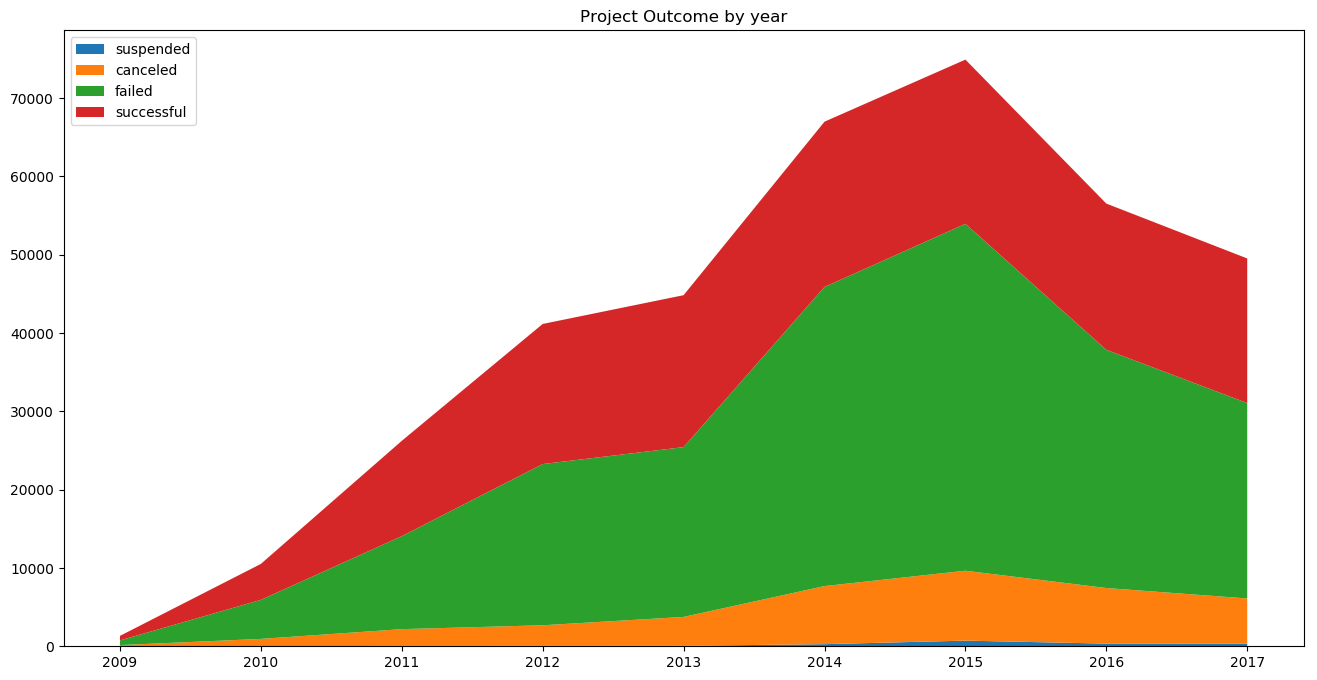

In [19]:
# Project outcome by year

mpl.style.use('default')
# plt.style.use('classic')
# sns.set_palette(sns.color_palette("Set2"))
plt.figure(figsize=(16,8))
plt.stackplot(df_4.index, 
              df_4["suspended"], df_4["canceled"], df_4["failed"], df_4["successful"],
              labels=['suspended','canceled','failed', 'successful'])
plt.legend(loc='upper left')
plt.title('Project Outcome by year')
plt.show()

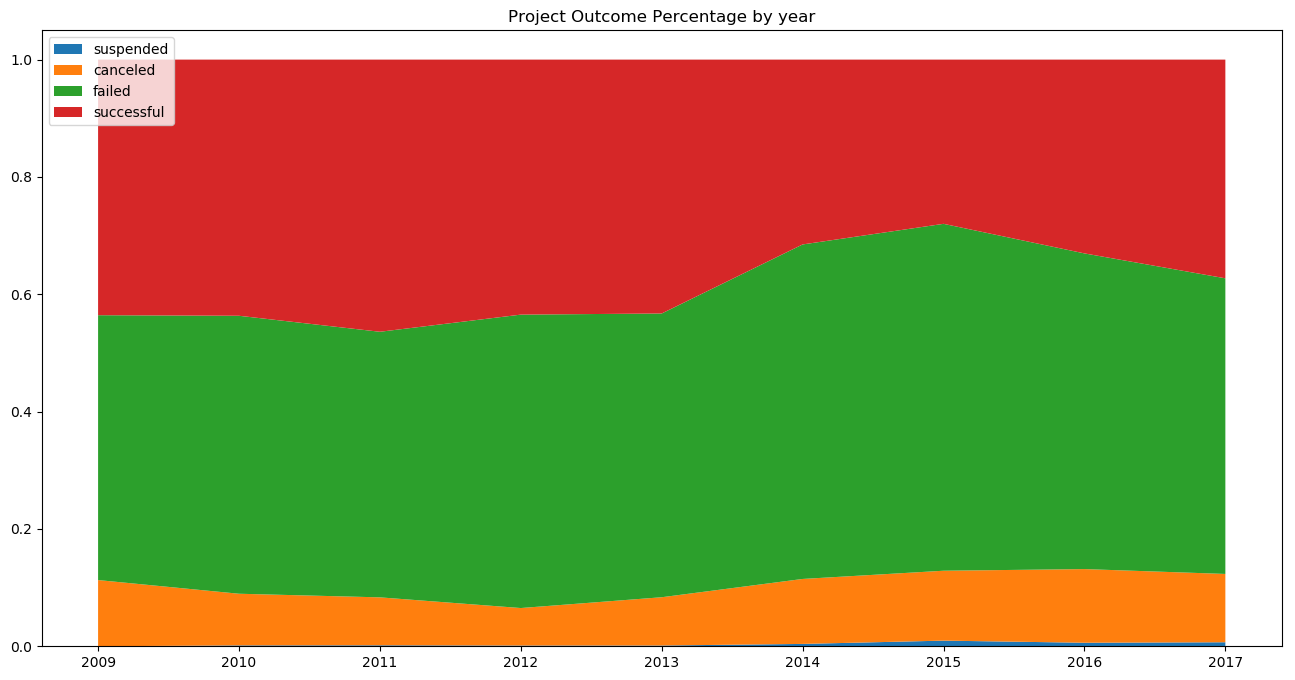

In [20]:
# Percent project outcome by year

# Transform the data to percentage
df_4_perc = df_4.divide(df_4.sum(axis=1), axis=0)
 
# Make the plot
plt.figure(figsize=(16,8))
plt.stackplot(df_4_perc.index, 
              df_4_perc["suspended"], df_4_perc["canceled"], df_4_perc["failed"], df_4_perc["successful"],
              labels=['suspended','canceled','failed', 'successful'])
plt.legend(loc='upper left')
plt.title('Project Outcome Percentage by year')
plt.show()

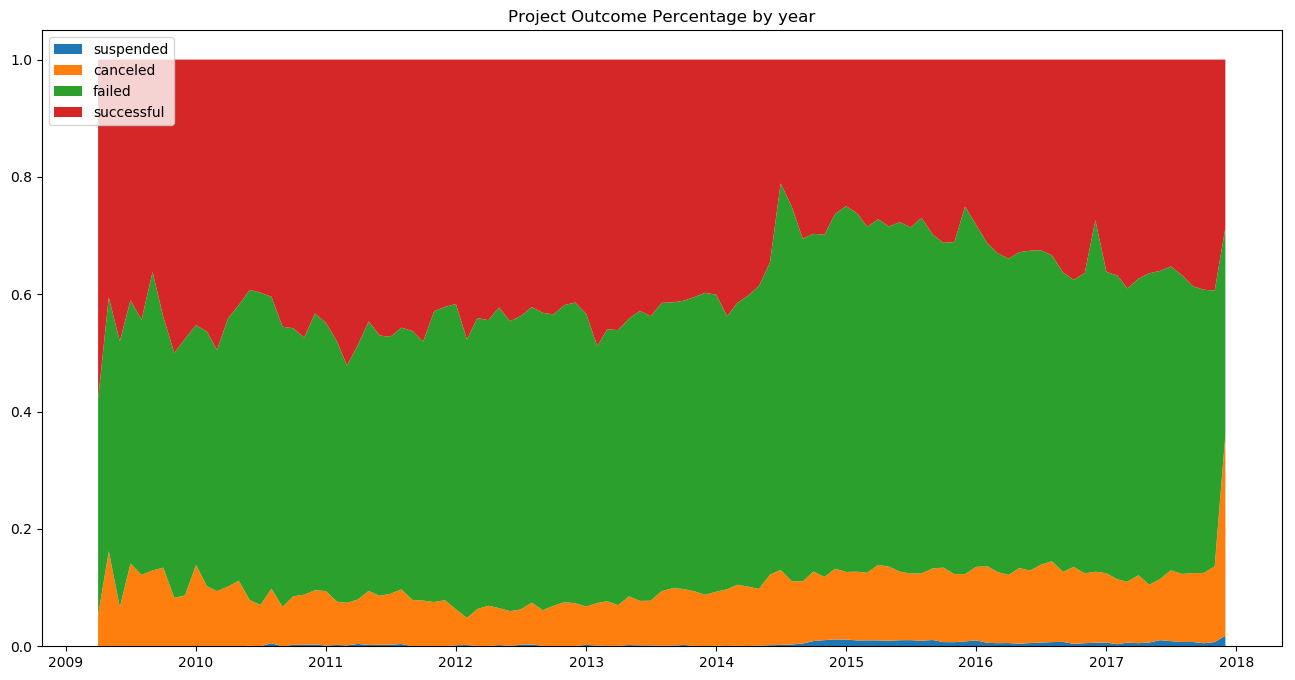

In [21]:
# Percent project outcome by month (see if there is a yearly pattern)

# Transform the data to percentage
df_7_perc = df_7.divide(df_7.sum(axis=1), axis=0)
 
# Make the plot
plt.figure(figsize=(16,8))
plt.stackplot(df_7_perc.index, 
              df_7_perc["suspended"], df_7_perc["canceled"], df_7_perc["failed"], df_7_perc["successful"],
              labels=['suspended','canceled','failed', 'successful'])
plt.legend(loc='upper left')
plt.title('Project Outcome Percentage by year')
plt.show()

In [22]:
# Project category funding (successfully funded projects) by year
df_5 = df_1[df_1.state == 'successful']
df_5 = df_5.groupby(['launch_year', 'main_category']).agg({'usd_pledged_real': 'sum'})
df_5 = df_5.unstack(level=-1)['usd_pledged_real']
df_5

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
launch_year,,,,,,,,,,,,,,,
2009,349826.94,79747.33,13089.00,21561.37,3.571922e+04,13543.99,664185.80,83853.05,7.003574e+04,53622.12,700861.17,80797.57,220850.49,7.540208e+04,66572.17
2010,1345933.49,460689.56,69784.19,326227.15,1.672275e+06,197121.92,10243987.82,788757.88,4.614313e+05,276340.14,6431651.69,841419.91,885000.23,7.477398e+05,1314750.85
2011,5458378.80,1532276.45,118592.24,1020860.96,1.234167e+07,1195282.93,28755771.94,2594624.55,3.821336e+06,522554.63,19447403.10,1745278.54,4244131.31,5.499397e+06,3901589.30
2012,8650052.11,8645455.94,312016.77,1664339.17,4.381018e+07,5331568.16,48150108.11,9204632.40,8.237084e+07,1116987.69,31571720.93,2675952.50,12057768.43,2.474524e+07,6152967.69
2013,11380514.59,11641577.41,1414292.99,2154871.17,6.108964e+07,17239841.18,72428388.15,17213870.20,9.907391e+07,1083835.27,30234284.33,3743951.69,18352704.22,6.504869e+07,7450357.50
2014,12820139.94,8813945.45,1735115.00,2489310.39,8.611928e+07,19181094.80,53203375.30,23122220.50,7.585796e+07,1595525.97,27074279.27,5766409.12,18406137.42,1.035012e+08,7035551.02
2015,13456894.58,12116763.66,2770603.84,1596042.83,1.463323e+08,25346756.19,54221599.50,20882166.10,1.332812e+08,2414389.11,22277349.44,6342378.03,19474877.05,1.407705e+08,5606351.72
2016,11923348.43,11824587.70,3102777.06,1691505.72,1.660709e+08,23140416.86,34499381.75,16466345.62,1.363902e+08,1927518.91,20653512.38,6199452.28,20522360.58,1.342643e+08,4526706.32
2017,14861420.84,11399983.59,2370537.83,1178890.93,1.456740e+08,21817079.07,27382016.39,15214570.99,1.475085e+08,1478315.88,18755110.94,6023496.82,21910172.20,1.214987e+08,2973616.89


In [42]:
# Project category trend in terms of number of proejcts (successfully funded projects only)

# df_6 = df_1[df_1.state == 'successful']
df_6 = df_1.copy()
df_6 = df_6.groupby(['launch_year', 'main_category']).size()
df_6 = df_6.unstack(level=-1)
df_6

main_category,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
launch_year,,,,,,,,,,,,,,,
2009,169,23,11,8,31,26,329,32,46,41,295,73,129,60,56
2010,856,266,55,169,166,173,3685,258,234,188,2466,466,705,225,607
2011,2339,590,117,413,903,603,8003,628,801,170,6615,870,2256,457,1471
2012,3433,1165,316,510,1841,1647,9397,1810,2781,278,8860,1184,5349,812,1778
2013,3440,1396,483,541,3246,2410,9534,2259,4090,209,6887,1239,5801,1826,1475
2014,5044,1582,1922,703,5394,4341,9697,6462,6008,930,7062,2376,7214,6455,1803
2015,5321,1922,2587,623,6704,5276,9695,6162,7418,1472,7069,2189,7094,9703,1684
2016,3581,1870,1773,430,5905,4120,6831,3791,6937,839,5400,1340,5560,7026,1132
2017,3774,1928,1469,352,5570,3966,5191,3014,6622,596,4594,993,4971,5621,864


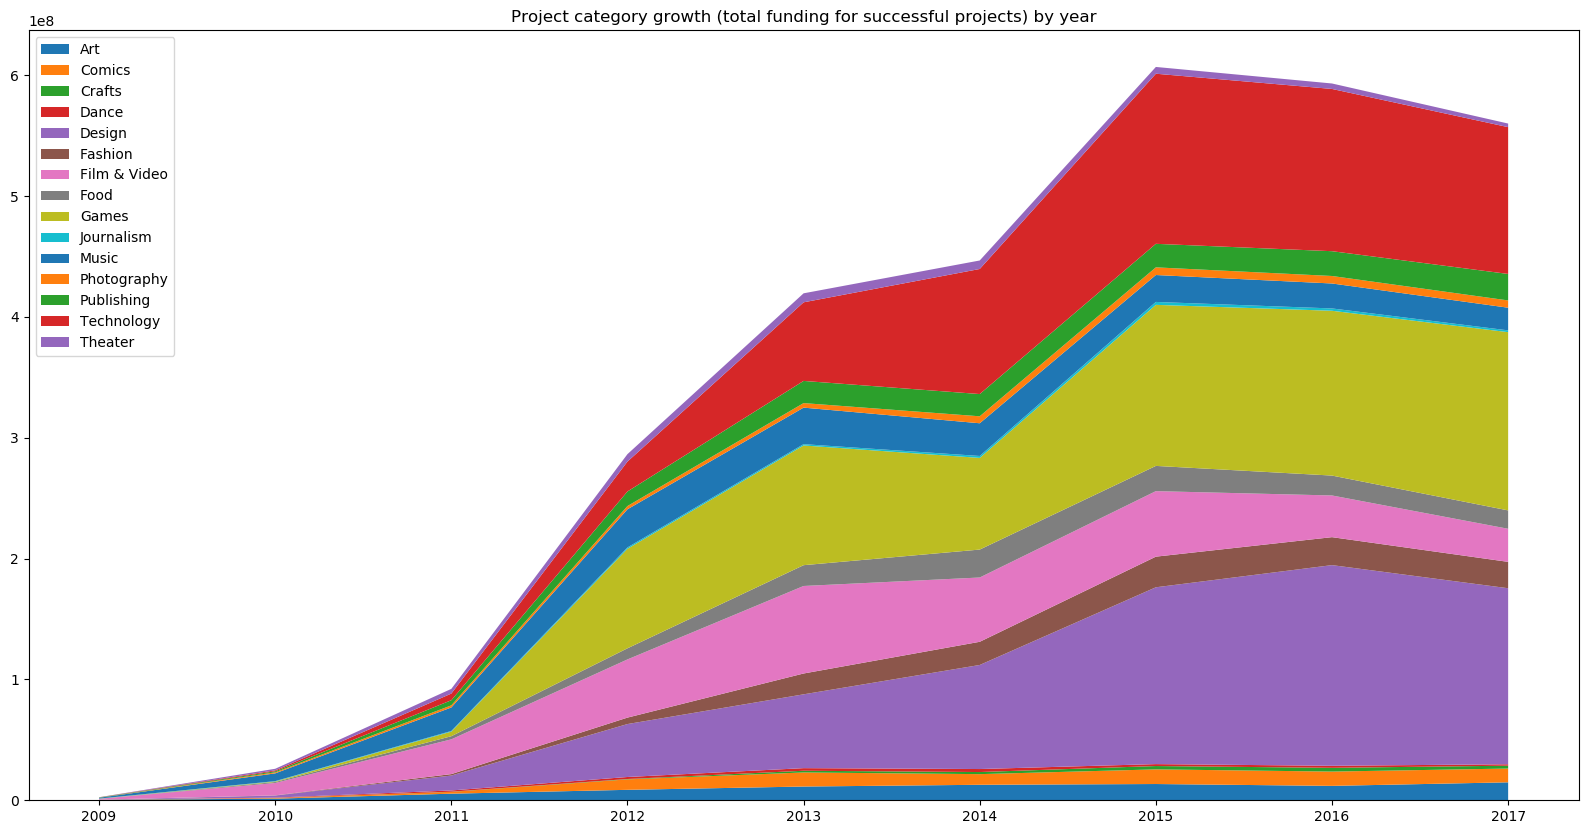

In [37]:
# Project category growth in terms of total funding (successfully funded projects only)

plt.figure(figsize=(20,10))
plt.stackplot(df_5.index, 
              df_5["Art"], df_5["Comics"], df_5["Crafts"], df_5["Dance"], df_5["Design"],
              df_5["Fashion"], df_5["Film & Video"], df_5["Food"], df_5["Games"], df_5["Journalism"],
              df_5["Music"], df_5["Photography"], df_5["Publishing"], df_5["Technology"], df_5["Theater"],
              labels=['Art',
                     'Comics',
                     'Crafts',
                     'Dance',
                     'Design',
                     'Fashion',
                     'Film & Video',
                     'Food',
                     'Games',
                     'Journalism',
                     'Music',
                     'Photography',
                     'Publishing',
                     'Technology',
                     'Theater'])
plt.legend(loc='upper left')
plt.title('Project category growth (total funding for successful projects) by year')
plt.show()

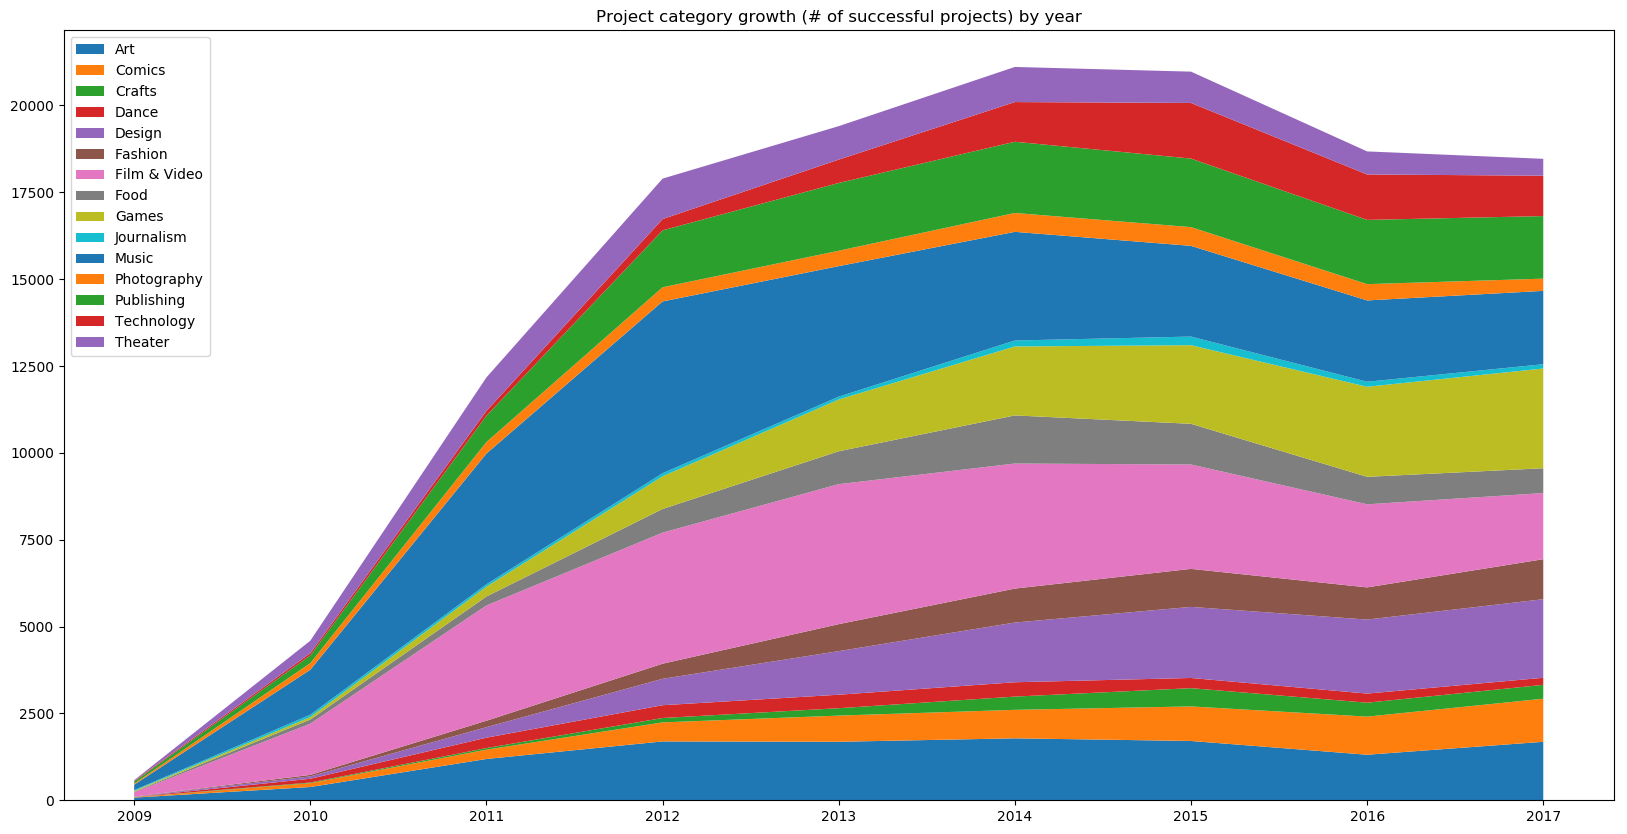

In [38]:
# Project category growth in terms of number of projects (successfully funded projects only)

plt.figure(figsize=(20,10))
plt.stackplot(df_6.index, 
              df_6["Art"], df_6["Comics"], df_6["Crafts"], df_6["Dance"], df_6["Design"],
              df_6["Fashion"], df_6["Film & Video"], df_6["Food"], df_6["Games"], df_6["Journalism"],
              df_6["Music"], df_6["Photography"], df_6["Publishing"], df_6["Technology"], df_6["Theater"],
              labels=['Art',
                     'Comics',
                     'Crafts',
                     'Dance',
                     'Design',
                     'Fashion',
                     'Film & Video',
                     'Food',
                     'Games',
                     'Journalism',
                     'Music',
                     'Photography',
                     'Publishing',
                     'Technology',
                     'Theater'])
plt.legend(loc='upper left')
plt.title('Project category growth (# of successful projects) by year')
plt.show()

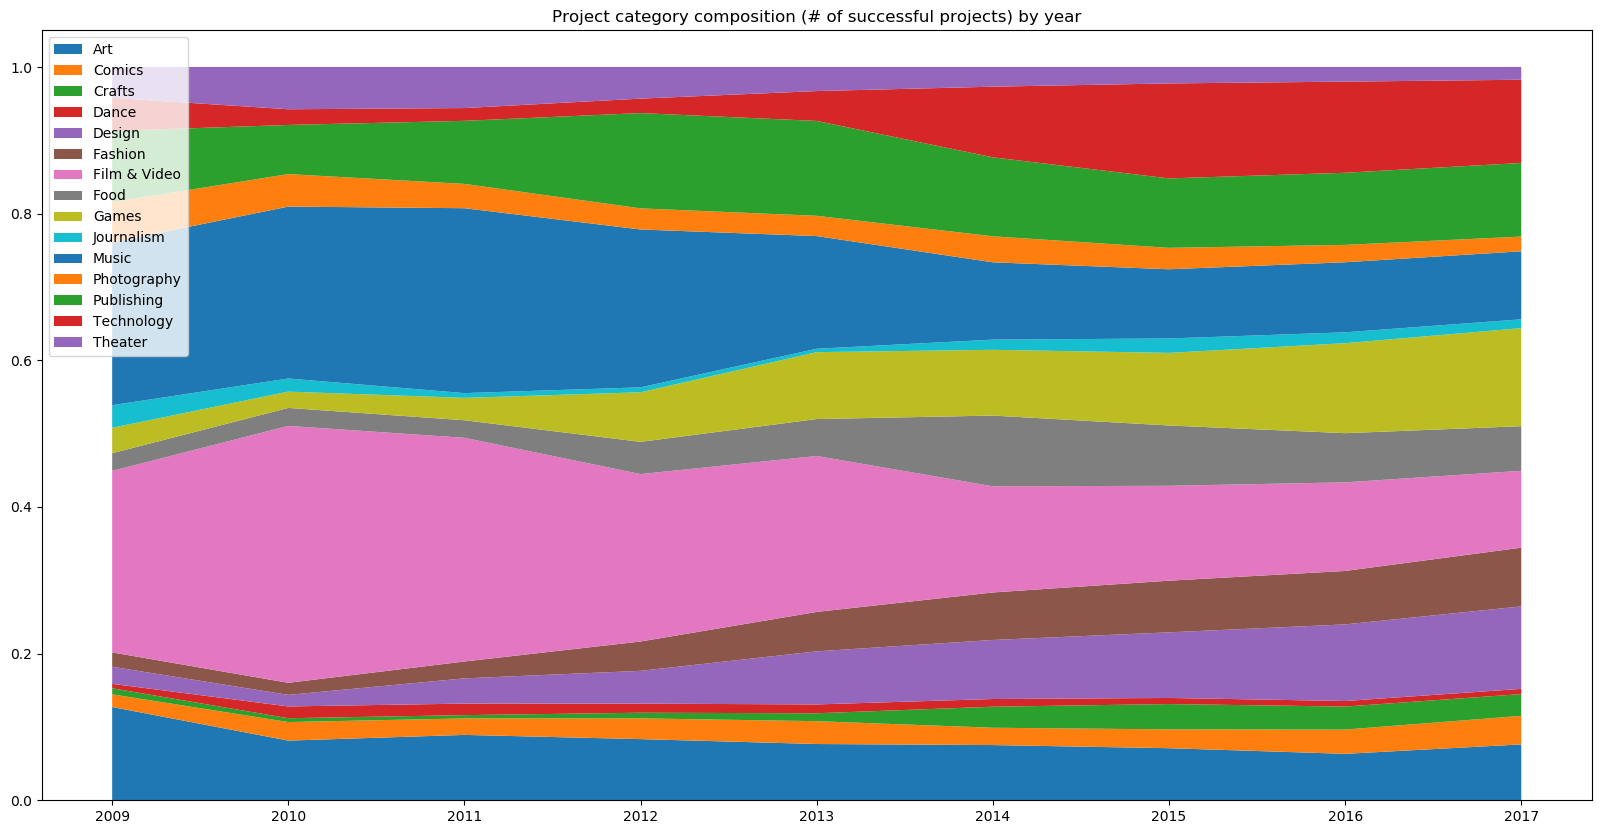

In [43]:
# Project category composition in terms of number of projects (successfully funded projects only)

# Transform to percentage
df_6_perc = df_6.divide(df_6.sum(axis=1), axis=0)

# Make the plot
plt.figure(figsize=(20,10))
plt.stackplot(df_6_perc.index, 
              df_6_perc["Art"], df_6_perc["Comics"], df_6_perc["Crafts"], df_6_perc["Dance"], df_6_perc["Design"],
              df_6_perc["Fashion"], df_6_perc["Film & Video"], df_6_perc["Food"], df_6_perc["Games"], df_6_perc["Journalism"],
              df_6_perc["Music"], df_6_perc["Photography"], df_6_perc["Publishing"], df_6_perc["Technology"], df_6_perc["Theater"],
              labels=['Art',
                     'Comics',
                     'Crafts',
                     'Dance',
                     'Design',
                     'Fashion',
                     'Film & Video',
                     'Food',
                     'Games',
                     'Journalism',
                     'Music',
                     'Photography',
                     'Publishing',
                     'Technology',
                     'Theater'])
plt.legend(loc='upper left')
plt.title('Project category composition (# of successful projects) by year')
plt.show()

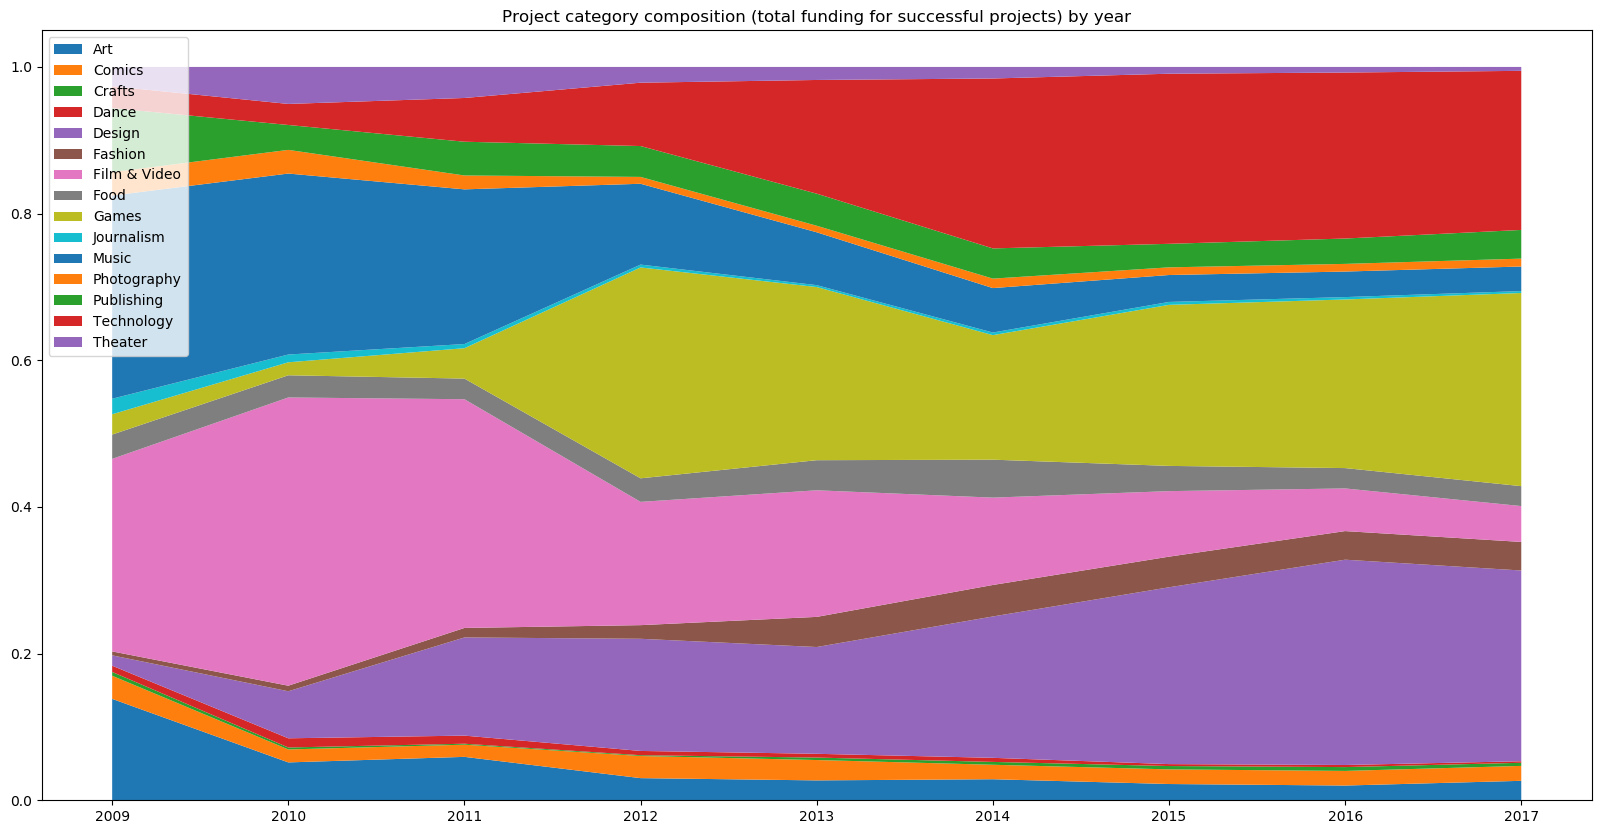

In [27]:
# Project category composition in terms of total funding (successfully funded projects only)

# Transform to percentage
df_5_perc = df_5.divide(df_5.sum(axis=1), axis=0)

# Make the plot
plt.figure(figsize=(20,10))
plt.stackplot(df_5_perc.index, 
              df_5_perc["Art"], df_5_perc["Comics"], df_5_perc["Crafts"], df_5_perc["Dance"], df_5_perc["Design"],
              df_5_perc["Fashion"], df_5_perc["Film & Video"], df_5_perc["Food"], df_5_perc["Games"], df_5_perc["Journalism"],
              df_5_perc["Music"], df_5_perc["Photography"], df_5_perc["Publishing"], df_5_perc["Technology"], df_5_perc["Theater"],
              labels=['Art',
                     'Comics',
                     'Crafts',
                     'Dance',
                     'Design',
                     'Fashion',
                     'Film & Video',
                     'Food',
                     'Games',
                     'Journalism',
                     'Music',
                     'Photography',
                     'Publishing',
                     'Technology',
                     'Theater'])
plt.legend(loc='upper left')
plt.title('Project category composition (total funding for successful projects) by year')
plt.show()

# Note: it's interesting to see the main catogery in terms of funding shifting from
# Art, Film & Video, and Music in the early days to Design, Games, and Tech

In [40]:
df_5_perc.to_csv('df_5_perc.csv')

In [44]:
df_6_perc.to_csv('df_6_perc_all_proj.csv')

In [16]:
df_1.state.value_counts()

failed        197614
successful    133851
canceled       38749
suspended       1843
Name: state, dtype: int64

In [47]:
df_1.launch_year.value_counts()

2015    74919
2014    66993
2016    56536
2017    49525
2013    44836
2012    41163
2011    26237
2010    10519
2009     1329
Name: launch_year, dtype: int64

In [18]:
df_1.main_category.value_counts()

Film & Video    62363
Music           49248
Publishing      39079
Games           34938
Technology      32185
Design          29761
Art             27958
Food            24416
Fashion         22562
Theater         10870
Comics          10742
Photography     10730
Crafts           8733
Journalism       4723
Dance            3749
Name: main_category, dtype: int64

In [19]:
df_1.currency.value_counts()

USD    290881
GBP     33392
EUR     16890
CAD     14623
AUD      7769
SEK      1737
MXN      1645
NZD      1436
DKK      1097
CHF       746
NOK       700
HKD       583
SGD       527
JPY        31
Name: currency, dtype: int64

In [20]:
df_1.country.value_counts()

US    290881
GB     33392
CA     14623
AU      7769
DE      4096
FR      2887
NL      2833
IT      2802
ES      2224
SE      1737
MX      1645
NZ      1436
DK      1097
IE       800
CH       746
NO       700
BE       605
HK       583
AT       582
SG       527
LU        61
JP        31
Name: country, dtype: int64

In [21]:
df_1.goal.describe()

count    3.720570e+05
mean     4.931920e+04
std      1.182582e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.650000e+04
max      1.000000e+08
Name: goal, dtype: float64

In [22]:
df_1.pledged.describe()

count    3.720570e+05
mean     9.755649e+03
std      9.626631e+04
min      0.000000e+00
25%      3.100000e+01
50%      6.250000e+02
75%      4.093000e+03
max      2.033899e+07
Name: pledged, dtype: float64

In [23]:
df_1.backers.describe()

count    372057.000000
mean        106.979850
std         914.530238
min           0.000000
25%           2.000000
50%          12.000000
75%          57.000000
max      219382.000000
Name: backers, dtype: float64

In [24]:
df_1.duration.describe()

count    372057.000000
mean         34.175177
std          12.793455
min           1.000000
25%          30.000000
50%          30.000000
75%          37.000000
max          92.000000
Name: duration, dtype: float64

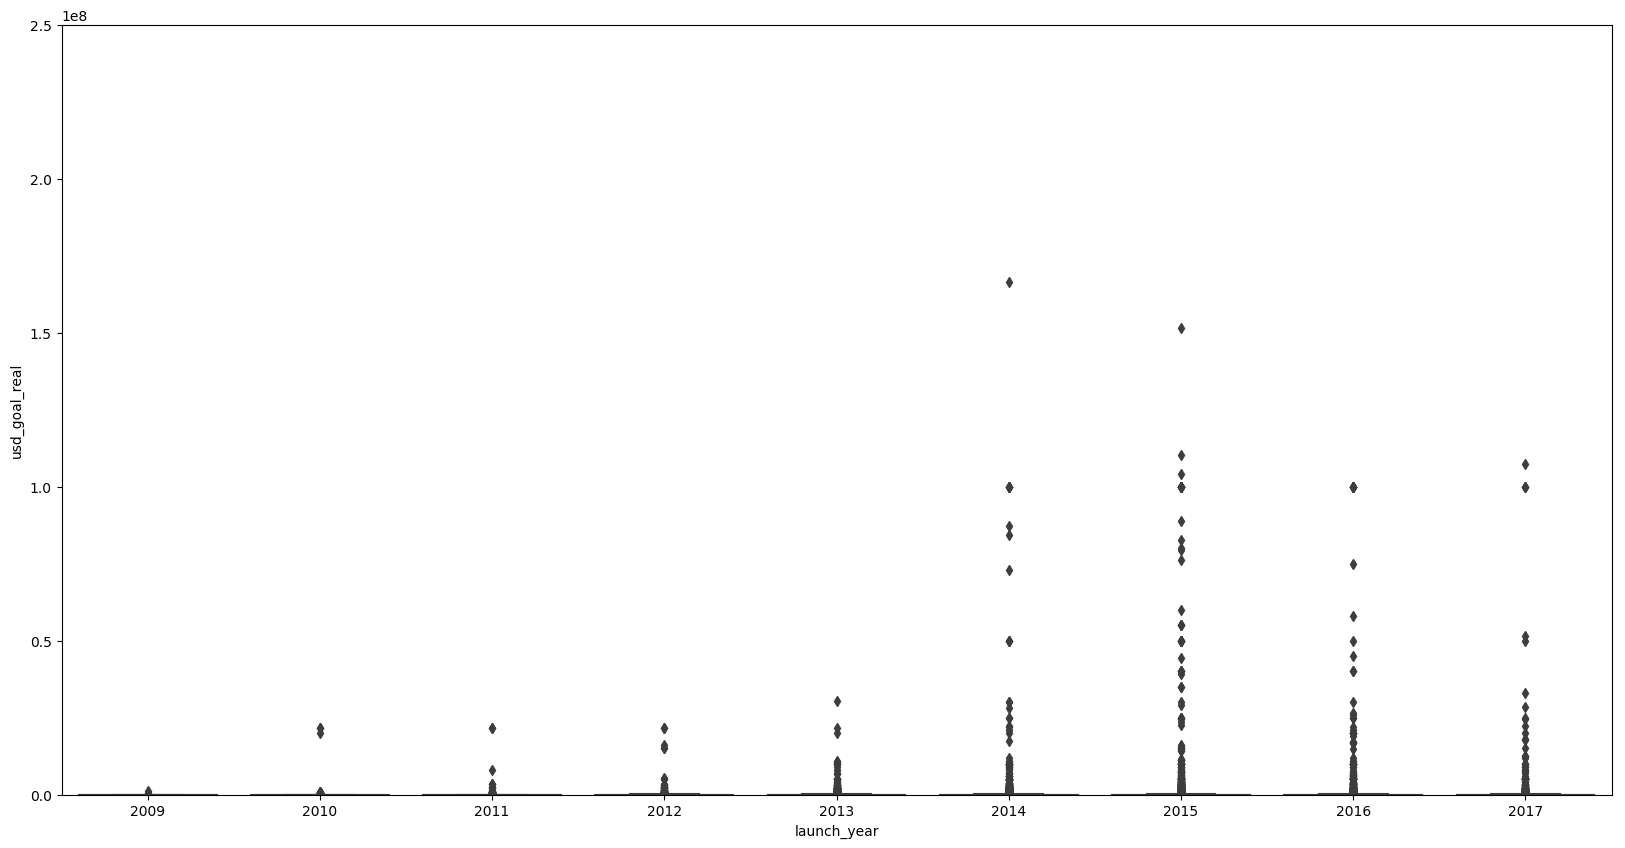

In [72]:
# Distribution of project funding goal for each year (linear scale)

plt.figure(figsize=(20,10))
plt.ylim(0, 2.5e8) 
ax = sns.boxplot(x='launch_year', y='usd_goal_real', data=df_1, width=0.8, whis=1.5)

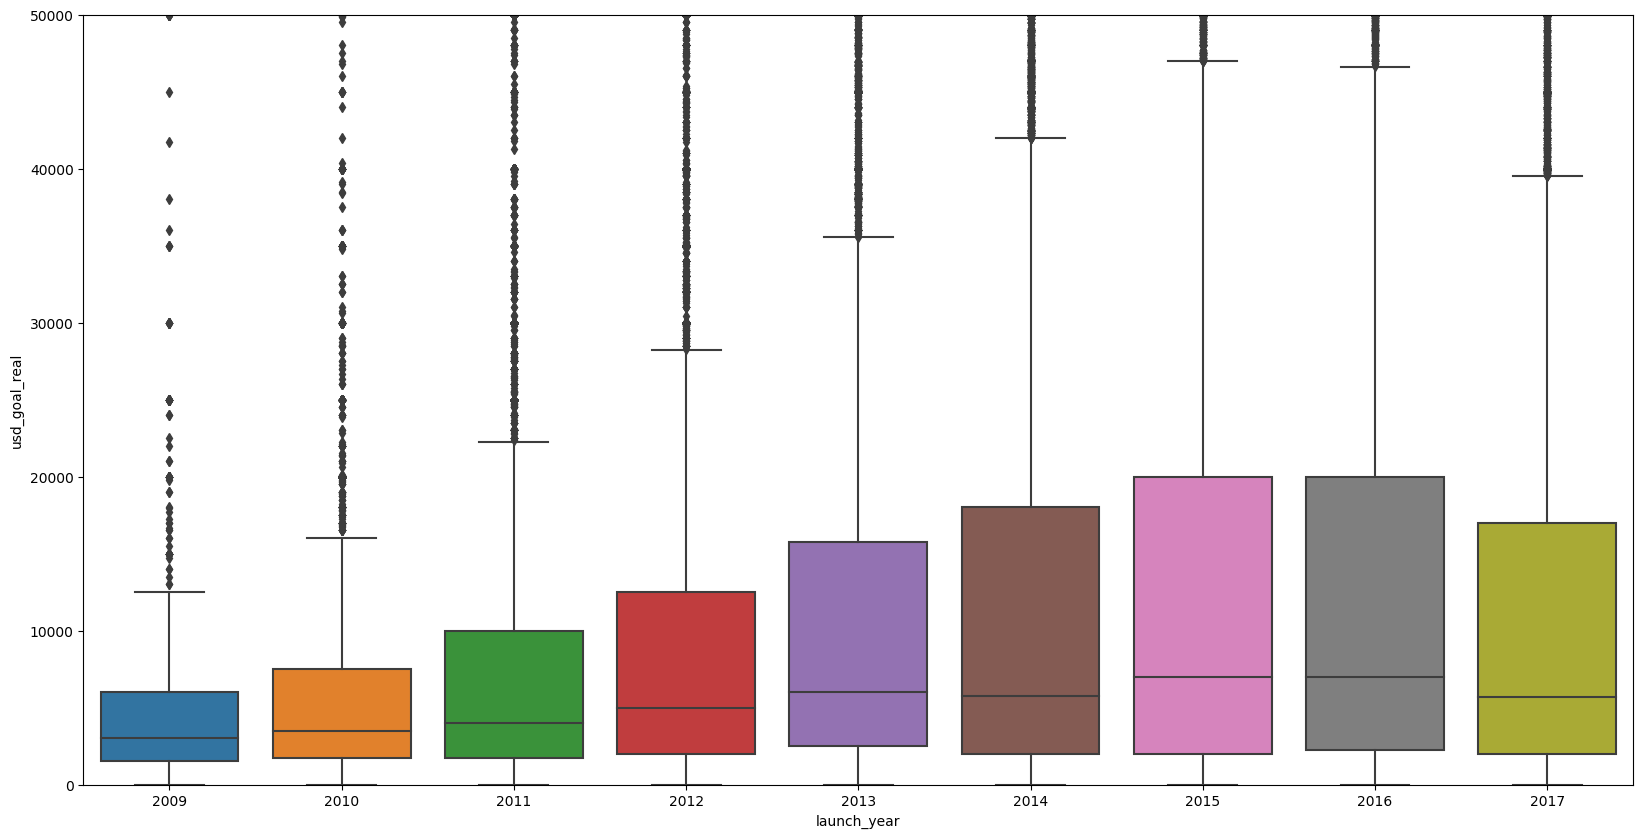

In [54]:
# Distribution of project funding goal for each year (linear scale with y-axis max=$50,000)

plt.figure(figsize=(20,10))
plt.ylim(0, 0.5e5) 
ax = sns.boxplot(x='launch_year', y='usd_goal_real', data=df_1, width=0.8, whis=1.5)

# Q: Are the creators of Kickstarter projects becoming more ambitious with their crowdfunding projects?
# A: Yes

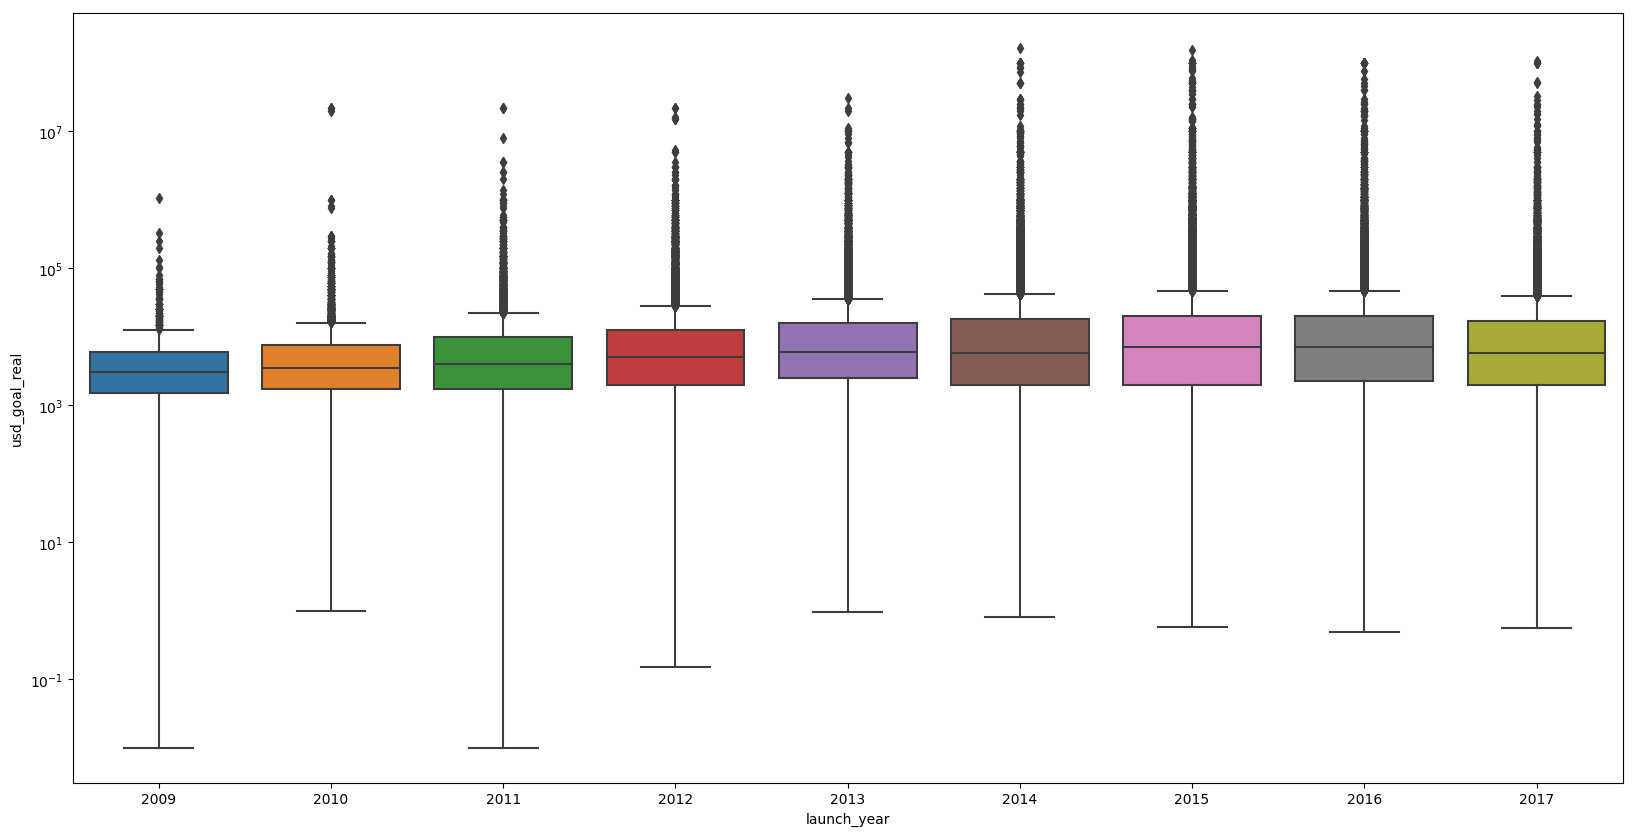

In [55]:
# Distribution of project funding goal for each year (log scale)

plt.figure(figsize=(20,10))
plt.yscale('log')
ax = sns.boxplot(x='launch_year', y='usd_goal_real', data=df_1, width=0.8)

# ax.set_yscale('log')

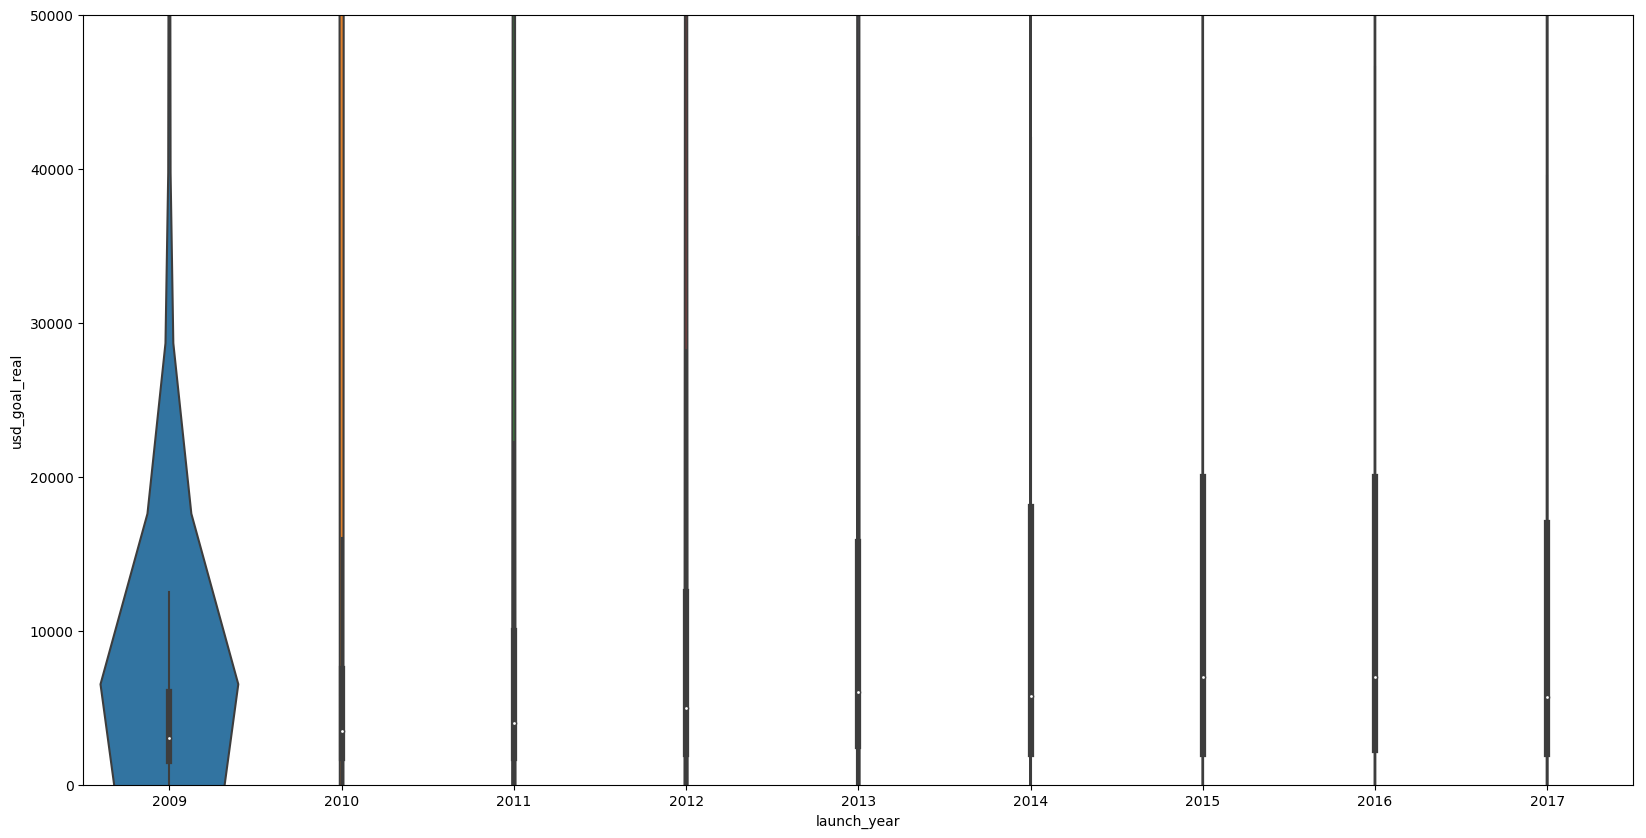

In [56]:
# Distribution of project funding goal for each year (linear scale with y-axis max=$50,000)

plt.figure(figsize=(20,10))
plt.ylim(0, 0.5e5) 
ax = sns.violinplot(x='launch_year', y='usd_goal_real', data=df_1, scale='area')

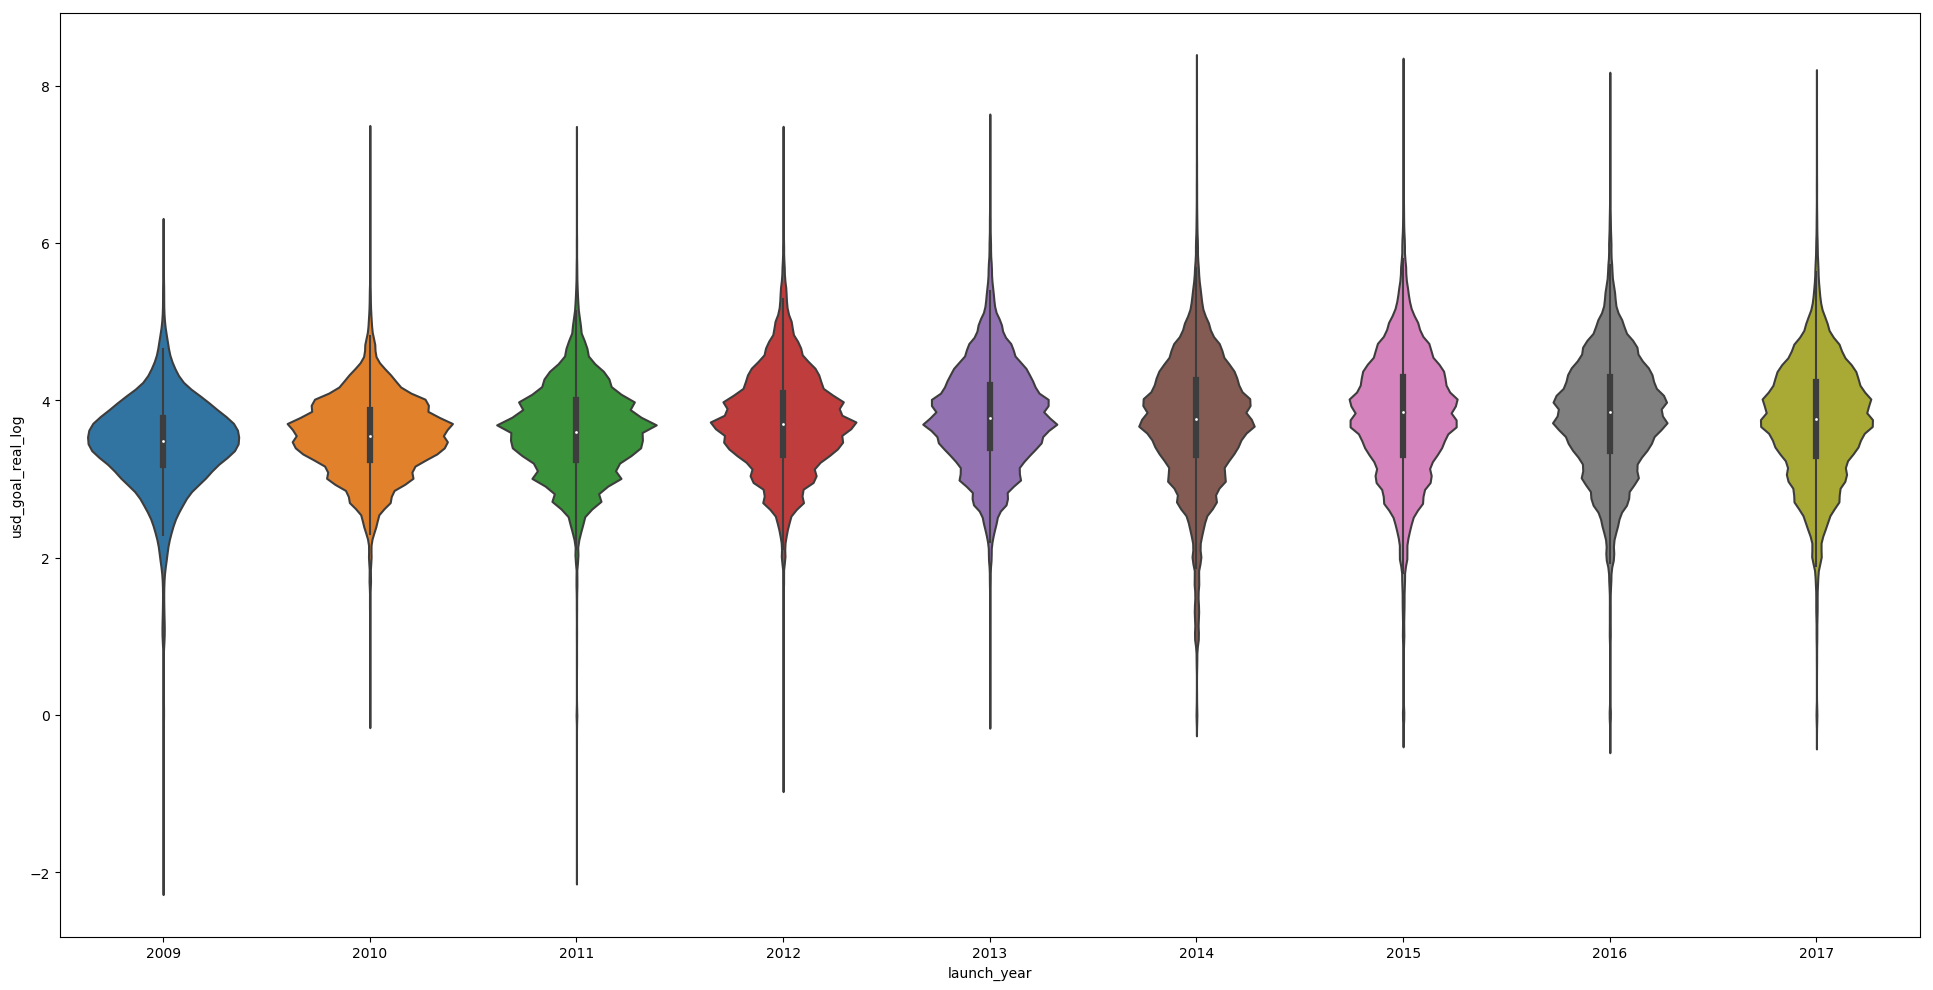

In [68]:
# Distribution of project funding goal for each year (log scale)

plt.figure(figsize=(24,12))
# plt.ylim(0, 1e6) 
# plt.yscale('log') 
ax = sns.violinplot(x='launch_year', y='usd_goal_real_log', data=df_1, scale='area')

# ax.set_yscale('log')

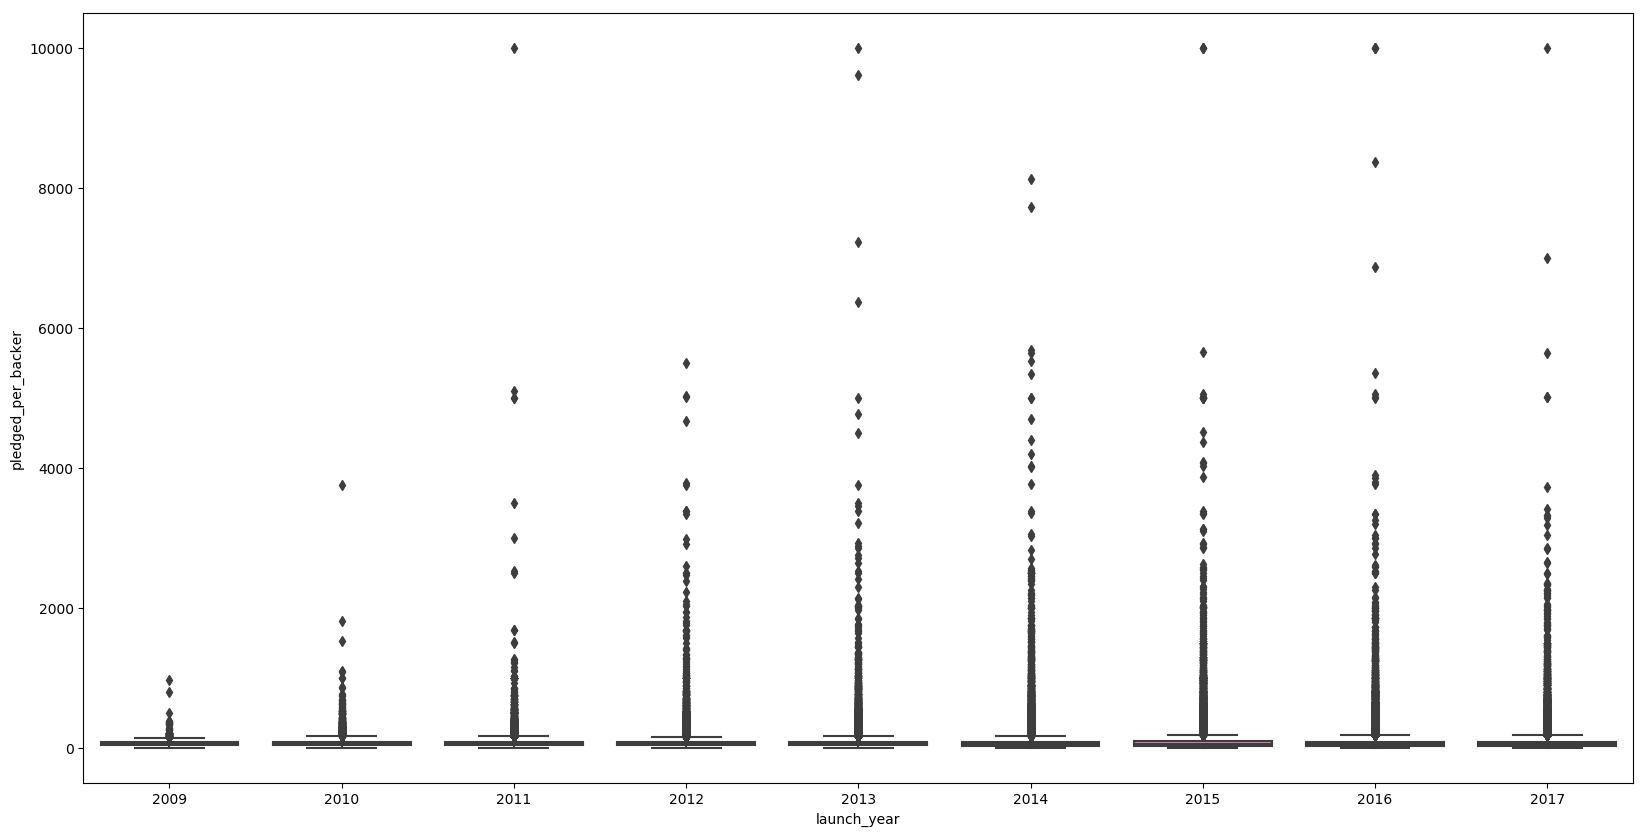

In [59]:
# Distribution of pledge per backer for projects that received at least 1 pledge, regardless of campaign outcome

plt.figure(figsize=(20,10))
ax = sns.boxplot(x='launch_year', y='pledged_per_backer', data=df_2, whis=1.5)

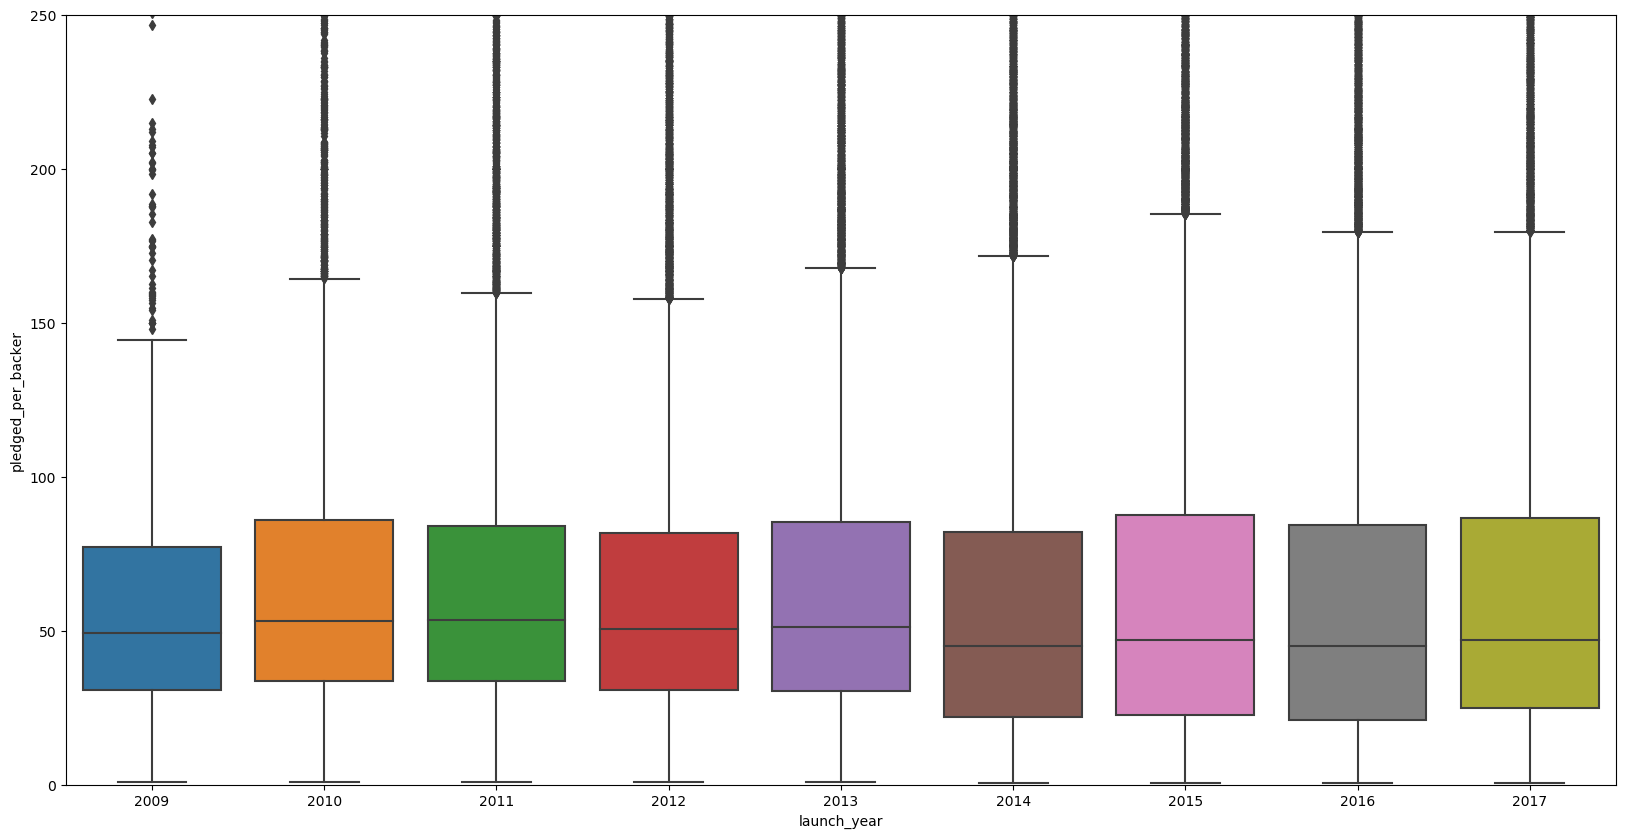

In [60]:
# Distribution of pledge per backer for projects that received at least 1 pledge, regardless of campaign outcome

plt.figure(figsize=(20,10))
plt.ylim(0, 0.25e3) 
ax = sns.boxplot(x='launch_year', y='pledged_per_backer', data=df_2, whis=1.5)

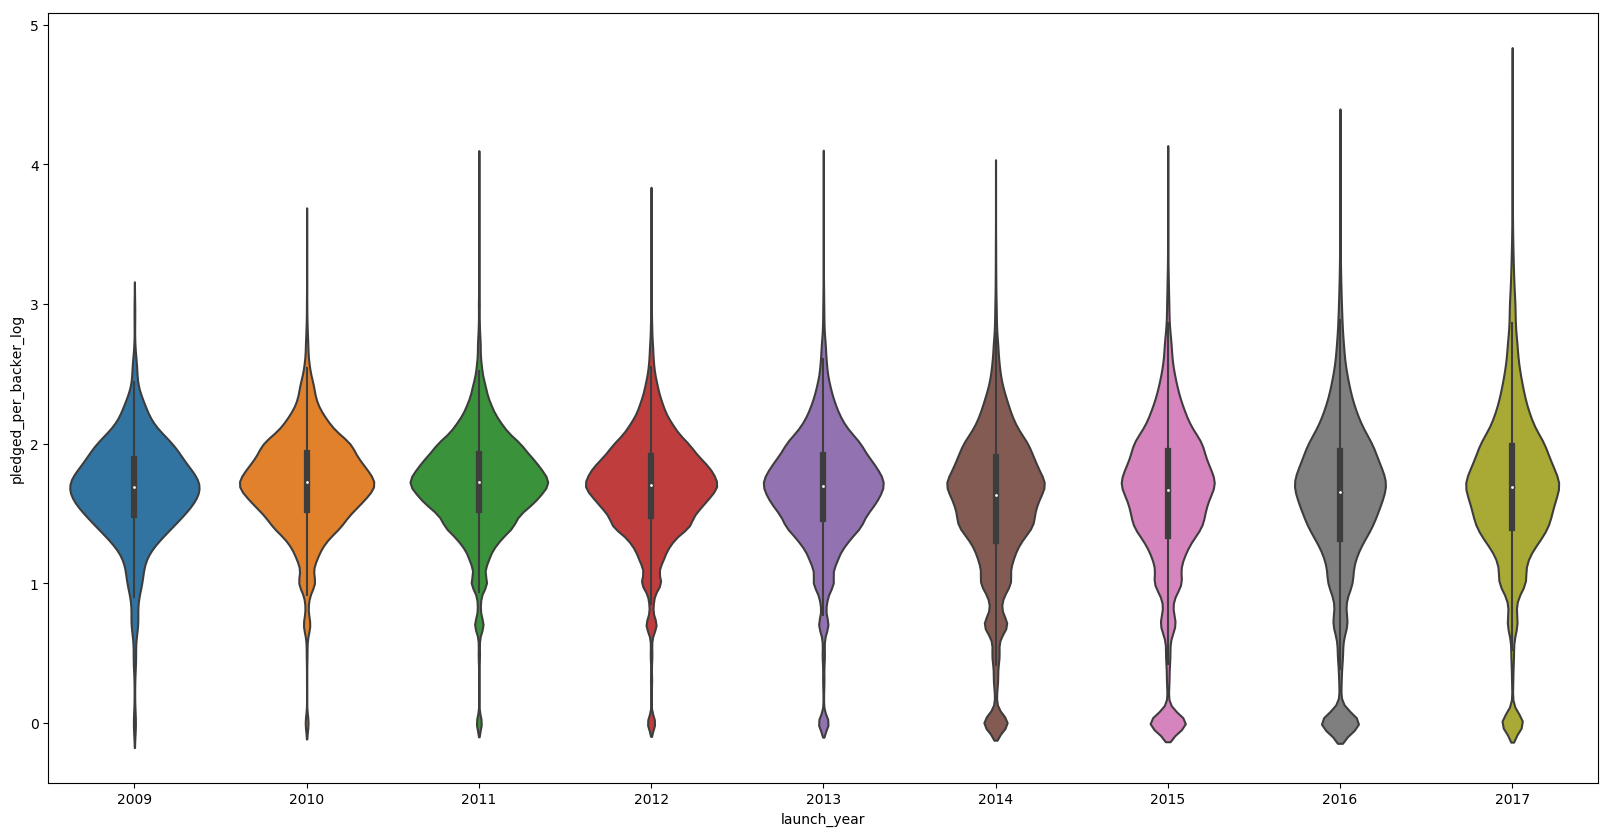

In [32]:
# Distribution of pledge per backer for projects that received at least 1 pledge, regardless of campaign outcome
# Note the concentration near 10^0= $1. These are projects that received "emotional support" from kind backers
# but eventually failed. Compare with distribution of pledge per backer for projects that were succesfully funded.

plt.figure(figsize=(20,10))
# plt.ylim(0, 1e6) 
# plt.yscale('log') 
ax = sns.violinplot(x='launch_year', y='pledged_per_backer_log', data=df_2, scale='area')

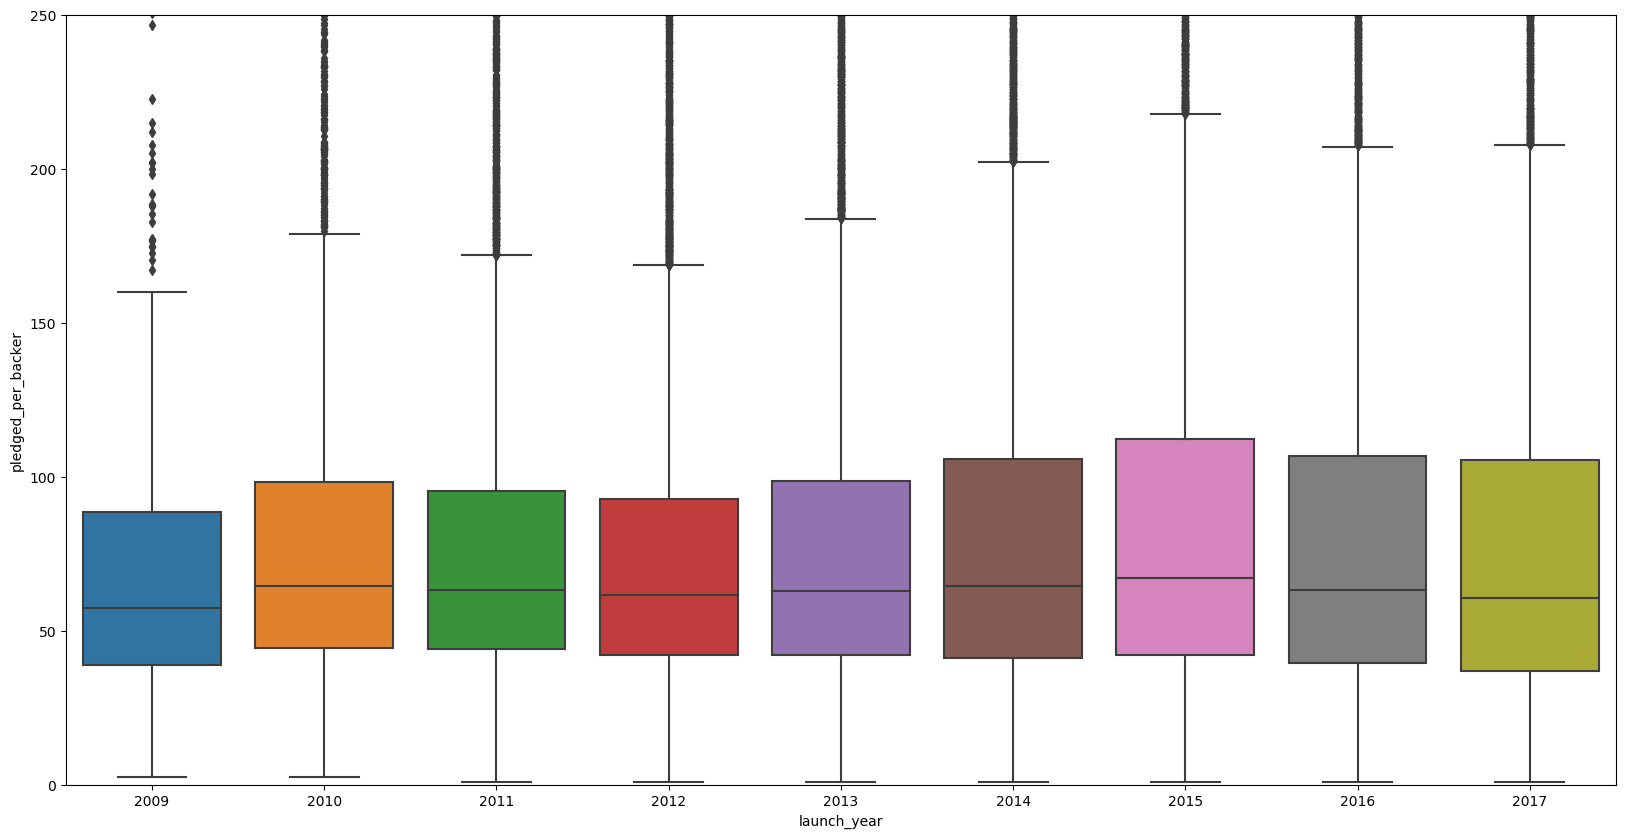

In [61]:
# Distribution of pledge per backer for projects that were succesfully funded

plt.figure(figsize=(20,10))
plt.ylim(0, 0.25e3) 
ax = sns.boxplot(x='launch_year', y='pledged_per_backer', data=df_3, whis=1.5)

# Q: Are people trusting the platform more over the years, as reflected by pledge amount per backer?
# A: Yes

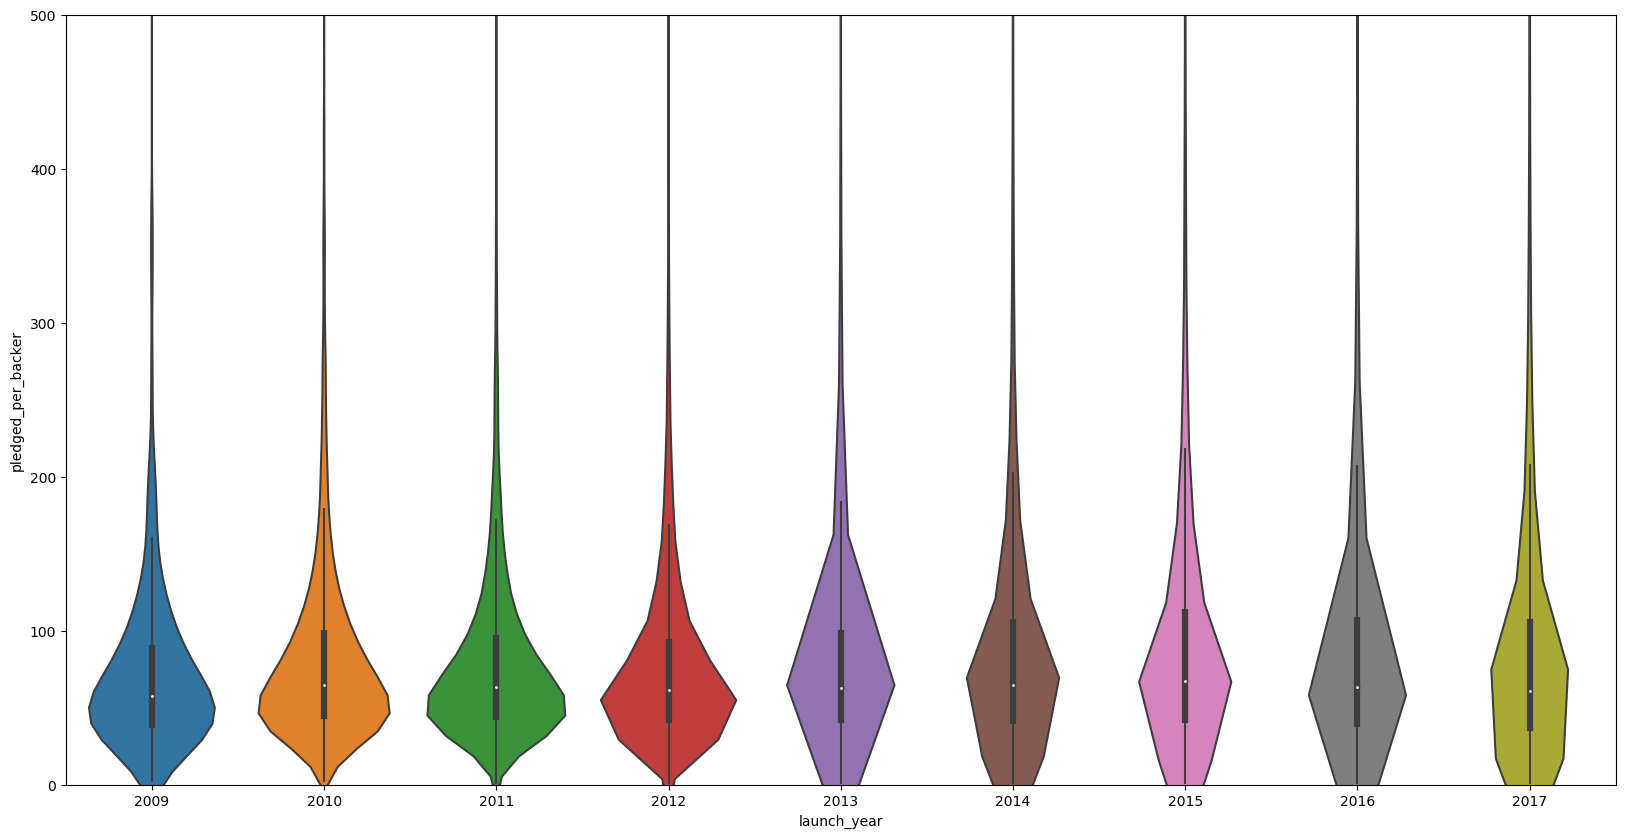

In [66]:
# Distribution of pledge per backer for projects that were succesfully funded

plt.figure(figsize=(20,10))
# plt.ylim(0, 1e6) 
# plt.yscale('log') 
plt.ylim(0, 0.5e3) 
ax = sns.violinplot(x='launch_year', y='pledged_per_backer', data=df_3, scale='area')

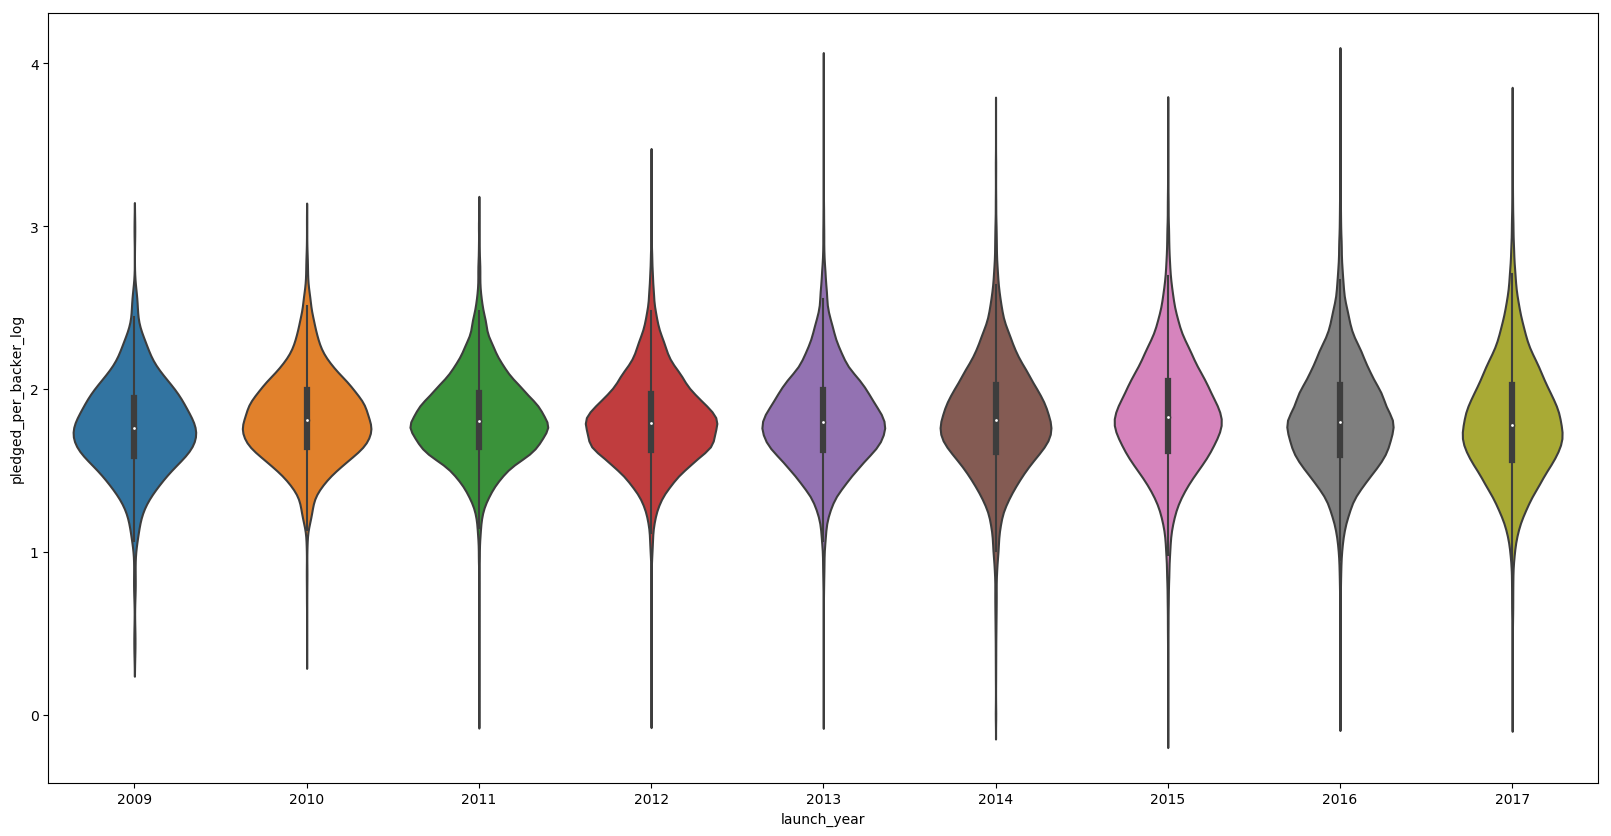

In [64]:
# Distribution of pledge per backer for projects that were succesfully funded

plt.figure(figsize=(20,10))
# plt.ylim(0, 1e6) 
# plt.yscale('log') 
ax = sns.violinplot(x='launch_year', y='pledged_per_backer_log', data=df_3, scale='area')